# GTEx data

Download using the following commands.
`wget https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt`

`wget https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz`

This notebook must be run in the `benchmark_env` conda environment.

In [1]:
library(edgeR)
library(limma)
library(ggplot2)
library(dplyr)
library(data.table)
library(biomaRt)
library(GSEABase)

Loading required package: limma


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int

In [3]:
# Load counts for protein coding genes.
gtex_counts_n10 <- fread("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz", nrows=10)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4523722,241.6,8300012,443.3,5587016,298.4
Vcells,8030441,61.3,18729213,142.9,18010709,137.5


In [4]:
# Load sample annotations and only keep those with counts.
gtex_annot <- fread("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt")
gtex_annot <- gtex_annot[gtex_annot$SAMPID %in% colnames(gtex_counts_n10),]
gtex_annot$SMTS <- gsub(" ", ".", gtex_annot$SMTS, fixed=T)
gtex_annot <- gtex_annot[gtex_annot$SMTS %in% c("Brain", "Muscle", "Kidney", "Liver"),]

In [5]:
# Sample at most 20 data sets per tissue.
sel <- c()
n_samples <- 10
for (tissue in unique(gtex_annot$SMTS) ) {
    n_tissue <- sum(gtex_annot$SMTS == tissue)
    if(n_tissue > n_samples) {
        sel <- c(sel, 
                 sample(which(gtex_annot$SMTS == tissue),
                        replace = FALSE,size = min(n_tissue, n_samples)))
    }
}
gtex_annot <- gtex_annot[sel,]
gtex_annot <- gtex_annot[order(gtex_annot$SAMPID),]
dim(gtex_annot)

[1] 40 63

In [6]:
sum(table(gtex_annot$SMTS))

[1] 40

In [7]:
# Load counts for protein coding genes.
gtex_counts <- fread("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz")
gtex_counts$Name <- gsub("\\.\\d+", "", gtex_counts$Name)
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
genes <- getBM(attributes = c('ensembl_gene_id', 'gene_biotype'), mart = ensembl)
genes <- genes[genes$gene_biotype == "protein_coding",]
gtex_counts <- gtex_counts[gtex_counts$Name %in% genes$ensembl_gene_id,]

In [8]:
sel.cols <- colnames(gtex_counts) %in% c("Name", "Description", gtex_annot$SAMPID)
gtex_counts <- gtex_counts[,sel.cols, with=FALSE]
gc()
dim(gtex_counts)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4757031,254.1,8300012,443.3,6476384,345.9
Vcells,9138435,69.8,1062878581,8109.2,1328594653,10136.4


[1] 19201    42

In [9]:
gtex_counts_mat <- as.matrix(gtex_counts[,3:dim(gtex_counts)[2]])
rownames(gtex_counts_mat) <- gtex_counts$Description

In [10]:
sum(gtex_annot$SAMPID == colnames(gtex_counts_mat))

[1] 40

In [11]:
dge <- DGEList(counts = gtex_counts_mat, group = gtex_annot$SMTS)
# Filter lowly expressed genes
keep <- rowSums(cpm(dge) > 0.5) > 2 #filterByExpr(dge)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [12]:
dim(dge)

[1] 16658    40

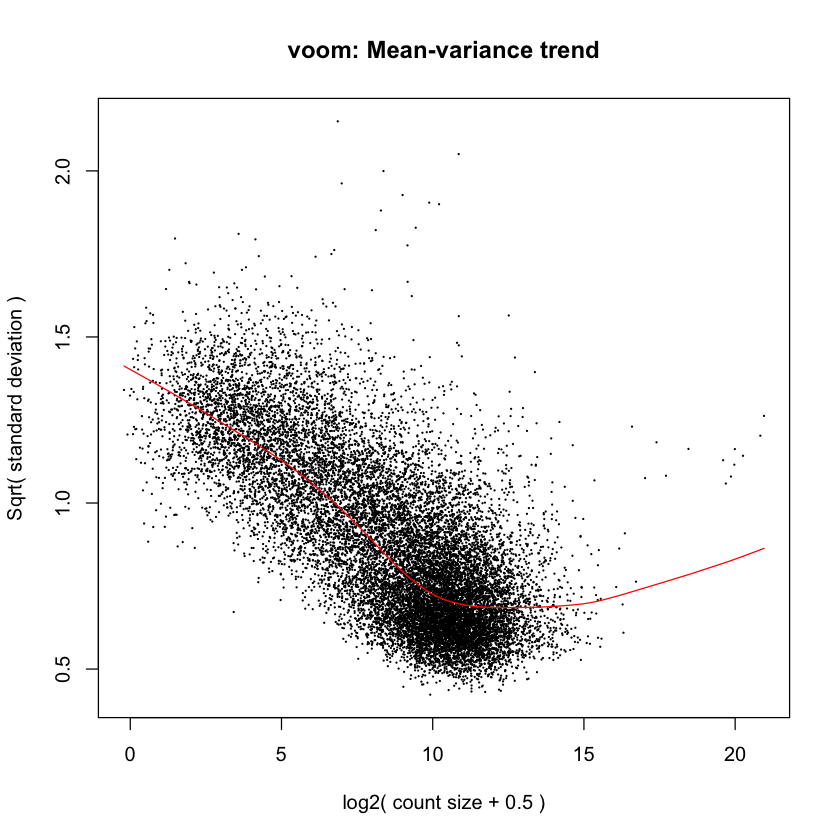

In [13]:
# Normalize the data
dge <- calcNormFactors(dge)
# Voom transformation
design <- model.matrix(~ 0 + SMTS, data = gtex_annot)
v <- voom(dge, design, plot = TRUE) 

In [14]:
# Fit linear model
fit <- lmFit(v, design)

In [25]:
# Create contrast matrix
contrast.matrix <- makeContrasts(
  Treatment_vs_Control =  SMTSBrain - SMTSLiver,
  levels = design
)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

# View top differentially expressed genes
top_genes <- topTable(fit2, adjust.method = "BH", number=Inf)

In [68]:
head(top_genes, 20)

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12763,ASGR1,-7.234100,2.054611688,-34.51855,1.573391e-31,2.081424e-27,60.85854
9533,APOA1,-14.145829,1.817743902,-34.11107,2.499008e-31,2.081424e-27,57.48247
15030,A1BG,-7.406088,3.266140187,-29.85231,4.392902e-29,1.602741e-25,55.68217
14809,ATF5,-7.638747,5.734446803,-27.65519,8.293177e-28,1.381477e-24,53.09953
8799,HPX,-11.599719,2.473328517,-28.14567,4.227609e-28,9.529541e-25,52.42732
1794,APOB,-14.698129,2.047295393,-29.28341,9.219758e-29,2.559712e-25,52.01379
11273,SERPINA10,-10.917680,-0.559667219,-28.00401,5.130207e-28,9.529541e-25,51.22638
646,C8B,-15.636240,-2.384045650,-30.07631,3.292444e-29,1.602741e-25,50.29326
7765,AMBP,-14.811382,1.154150489,-27.55197,9.569815e-28,1.449218e-24,50.07788


In [51]:
gmt_file <- "libs_human/gmt/WikiPathway_2023_Human.txt"
gene_sets <- getGmt(gmt_file)
gene_set_list <- setNames(lapply(gene_sets, function(x) geneIds(x)), names(gene_sets))

In [65]:
# CAMERA gene set enrichment analysis
camera_res <- camera(v, index = gene_set_list, design = design, contrast = contrast.matrix[,"Treatment_vs_Control"])

# View gene set enrichment results
camera_res[which(camera_res$FDR < 0.01 & camera_res$Direction == "Down"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
Complement And Coagulation Cascades WP558,58,Down,8.124711e-16,6.507893e-13
Folate Metabolism WP176,62,Down,1.659878e-12,6.647813e-10
Cholesterol Metabolism WP5304,70,Down,6.327542e-12,1.689454e-09
Complement System WP2806,94,Down,1.447304e-11,2.775522e-09
Complement Activation WP545,22,Down,1.732535e-11,2.775522e-09
Selenium Micronutrient Network WP15,81,Down,2.623186e-11,3.501954e-09
Disorders Of Bile Acid Synthesis And Biliary Transport WP5176,29,Down,4.484118e-11,4.489723e-09
Enterocyte Cholesterol Metabolism WP5333,35,Down,2.758156e-10,2.454759e-08
Tamoxifen Metabolism WP691,19,Down,3.782012e-10,3.029392e-08


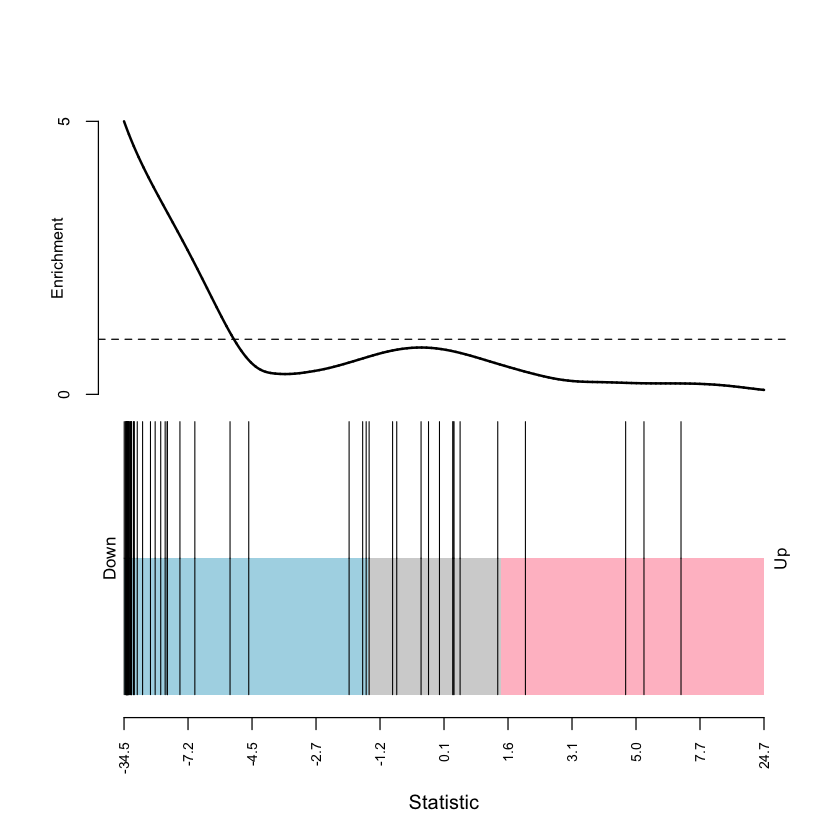

In [66]:
# Choose a gene set for the barcode plot
chosen_gene_set <- rownames(camera_res)[1]  # Choose the first gene set

# Get the gene indices for the chosen gene set
gene_indices <- gene_set_list[["Complement And Coagulation Cascades WP558"]]

# Create the barcode plot
barcodeplot(fit2$t[, 1], index = gene_indices, main = "")

Warning message:
“Removed 111 rows containing missing values or values outside the scale range (`geom_point()`).”


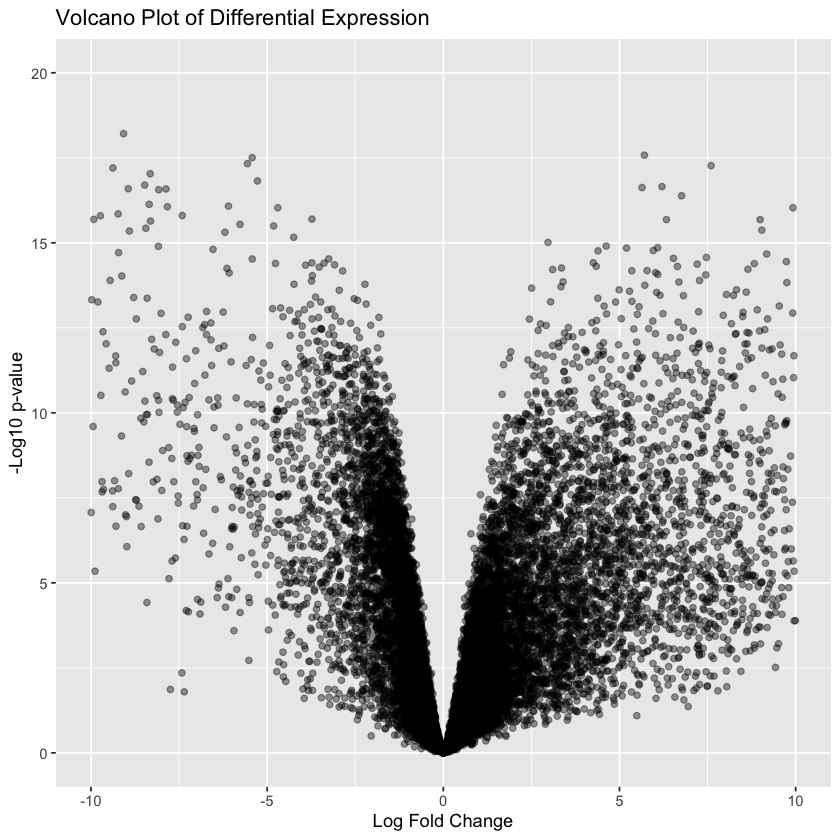

In [17]:
volcano <- ggplot(top_genes, aes(x = logFC, y = -log10(P.Value))) +
  geom_point(alpha = 0.4) +
  xlim(c(-10, 10)) +
  ylim(c(0, 20)) +
  xlab("Log Fold Change") +
  ylab("-Log10 p-value") +
  ggtitle("Volcano Plot of Differential Expression")
volcano